In [34]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [35]:
sns.set_style("white")
test_ratio = 0.0
data_step = 0.005
data_sigma1 = 2
data_sigma2 = 1
def func(x):
    return np.power(x, 3)

num_data = 20

data_x = np.random.uniform(-4, 4, size=num_data)
data_y = np.zeros(num_data)

num_data_true = 1000
data_x_true = np.linspace(-6, 6, num_data_true)
data_y_true = np.zeros(num_data_true)

In [36]:
for i in range(num_data):
    if (data_x[i] < 0):  # -3 <= x <0, sigma=2 (has more uncertainty inherently)
        data_y[i] = func(data_x[i]) + np.random.normal(0, 3)
    else:  # x>0, sigma=1 (less noisy measurement)
        data_y[i] = func(data_x[i]) + np.random.normal(0, 9)
        
for i in range(num_data_true):
    data_y_true[i] = func(data_x_true[i])

In [37]:
num_train_data = int(num_data * (1 - test_ratio))
num_test_data  = num_data - num_train_data

data_x = np.reshape(data_x, [num_data, 1])
data_y = np.reshape(data_y, [num_data, 1])
data_y_true = np.reshape(data_y_true, [num_data_true, 1])
data_x_true = np.reshape(data_x_true, [num_data_true, 1])

train_x = data_x[:num_train_data, :]
train_y = data_y[:num_train_data, :]
test_x  = data_x[num_train_data:, :]
test_y  = data_y[num_train_data:, :]

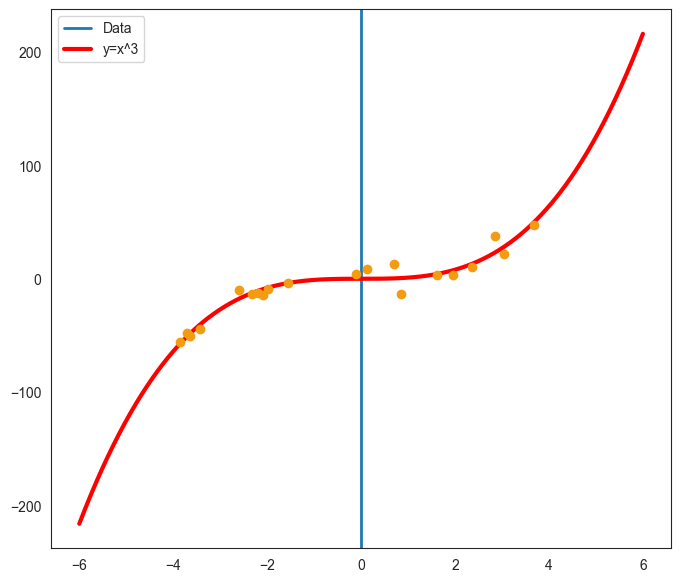

In [38]:
plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [61]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

In [62]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from joblib import Parallel,delayed
from sklearn import tree
from sklearn.base import clone 
from sklearn.linear_model import ElasticNet

In [63]:
import array
import numpy as np
import warnings
import scipy.sparse as sp
import itertools
import pandas

from sklearn.base import BaseEstimator, ClassifierMixin, clone, is_classifier
from sklearn.base import MultiOutputMixin
from sklearn.base import MetaEstimatorMixin, is_regressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_random_state
from sklearn.utils.deprecation import deprecated
from sklearn.utils.validation import _num_samples
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.validation import check_X_y, check_array
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.utils.multiclass import (_check_partial_fit_first_call,
                               check_classification_targets,
                               _ovr_decision_function)
from sklearn.utils.metaestimators import _safe_split, available_if
from sklearn.exceptions import NotFittedError

from joblib import Parallel

import copy

In [64]:
# Import Qiskit

from qiskit import QuantumCircuit as qct
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

from qiskit_aer.noise import NoiseModel
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import datetime

In [65]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        passmanager = generate_preset_pass_manager(optimization_level=3, backend=self.backend)
        job = passmanager.run(self._circuit)
        result = self.backend.run(job, 
              shots = self.shots,
              parameter_binds = [{self.theta: thetas}]).result()
        
        result = result.get_counts(0)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return probabilities, 1-probabilities#np.array([expectation])

In [66]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

pi = torch.tensor(np.pi)

def gaussian_nll(mean, variance, y):
    return torch.mean((torch.log(variance) * 0.5) + ((0.5 * (y - mean).square()) / variance)) + torch.log(2 * pi)
        
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(self.input_dim, 100)
        self.fc2 = nn.Linear(100, self.output_dim-1)
        self.hybrid = Hybrid(AerSimulator(), 100, np.pi / 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.hybrid(x)
        return x
    
class GaussianMultiLayerPerceptron(MultiLayerPerceptron):
    
    def __init__(self, input_dim, output_dim=2):
        super().__init__(input_dim, output_dim)
 
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.hybrid(x)
        #print("where", x)
        mean, variance = torch.split(x, 1, dim=1)
        variance = F.softplus(variance) + 1e-6 #Positive constraint
        return mean, variance

In [68]:
from torch.utils.data import TensorDataset, DataLoader
tensor_x = torch.Tensor(train_x) # transform to torch tensor
tensor_y = torch.Tensor(train_y)

toy_dataset = TensorDataset(tensor_x, tensor_y) # create your datset
dataloader = DataLoader(toy_dataset, num_workers=1, batch_size=1, shuffle=True) # create your dataloader

In [69]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl

data_range = 1

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    return perturbed_image

class MLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = MultiLayerPerceptron(1, 1)
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x = x.view(x.size(0), -1)
    y_hat = self.model(x)
    loss = self.loss(y_hat, y)
    self.log('train_loss', loss)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
    return optimizer

class GaussianMLP(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    self.model = GaussianMultiLayerPerceptron(1, 2)
    self.loss = gaussian_nll
    
  def forward(self, x):
    return self.model(x)
  
  def training_step(self, batch, batch_idx):
    x, y = batch
    x.requires_grad = True
    x = x.view(x.size(0), -1)
    mean, var = self.model(x)
    loss_for_adv = F.gaussian_nll_loss(mean, y, var)
    grad = torch.autograd.grad(loss_for_adv, x, retain_graph=False)[0]
    x = x.detach()
    y = y.detach()
    mean = mean.detach()
    var = var.detach()
    loss_for_adv.detach_()
    perturbed_data = fgsm_attack(x, 0.01 * data_range, grad) # 8 is range of data
    mean_adv, var_adv = self.model(perturbed_data)
    loss = F.gaussian_nll_loss(mean, y, var) + F.gaussian_nll_loss(mean_adv, y, var_adv)
    self.log('train_loss', loss)
    torch.nn.utils.clip_grad_norm_(self.model.parameters(), 100)
    return loss
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.1)
    return optimizer

In [70]:
mlp = GaussianMLP()#
trainer = pl.Trainer(devices=1, max_epochs=1)# accelerator="gpu",
trainer.fit(mlp, dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 301    | train
---------------------------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode
/Users/sozo/miniforge3/envs/cirqenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/sozo/miniforge3/envs/cirqenv/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50).

Training: |                                               | 0/? [00:00<?, ?it/s]

/var/folders/84/j8ty4k394jqc7pf_cxljx9_h0000gn/T/ipykernel_2016/2571825612.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  result = torch.tensor([expectation_z])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [48]:
mlp.eval()
means = []
variances = []

for x in data_x_true:
    mean, var = mlp(torch.Tensor(x).unsqueeze(0))
    means.append(mean.item())
    variances.append(var.item())

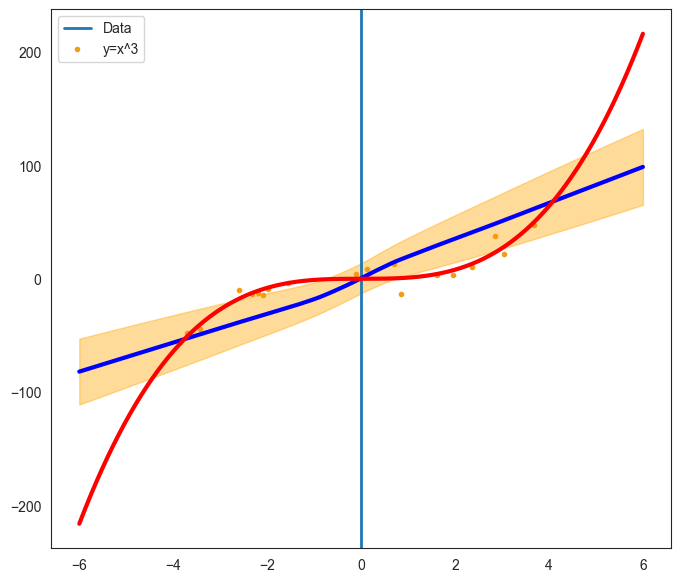

In [49]:
upper = [i + np.sqrt(k) * 3 for i, k in zip(means, variances)]
lower = [i - np.sqrt(k) * 3 for i, k in zip(means, variances)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x, data_y, '.', markersize=6, color='#F39C12')
plt.plot(data_x_true, means, linewidth=3, color='b')
plt.fill_between(data_x_true.flatten(), upper, lower, color="orange", alpha=0.4)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

In [72]:
models = []
import random
import pytorch_lightning as pl

for i in range(5):
    seed = random.randint(0, 9999)
    print(i, seed)
    pl.seed_everything(seed)
    mlp = GaussianMLP()
    trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=1)
    dataloader = DataLoader(toy_dataset, num_workers=1, batch_size=1, shuffle=True)
    trainer.fit(mlp, dataloader)
    models.append(mlp)

Seed set to 3182
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type                         | Params | Mode 
---------------------------------------------------------------
0 | model | GaussianMultiLayerPerceptron | 301    | train
---------------------------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


0 3182


/Users/sozo/miniforge3/envs/cirqenv/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/sozo/miniforge3/envs/cirqenv/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [52]:
import numpy as np
means = []
variances = []

for model in models:
    model.eval()
    preds = []
    sigmas = []

    for x in data_x_true:
        mu, sigma = model(torch.Tensor(x).unsqueeze(0))
        preds.append(mu.item())
        sigmas.append(sigma.item())
    
    means.append(preds)
    variances.append(sigmas)
means = torch.tensor(means)
variances = torch.tensor(variances)

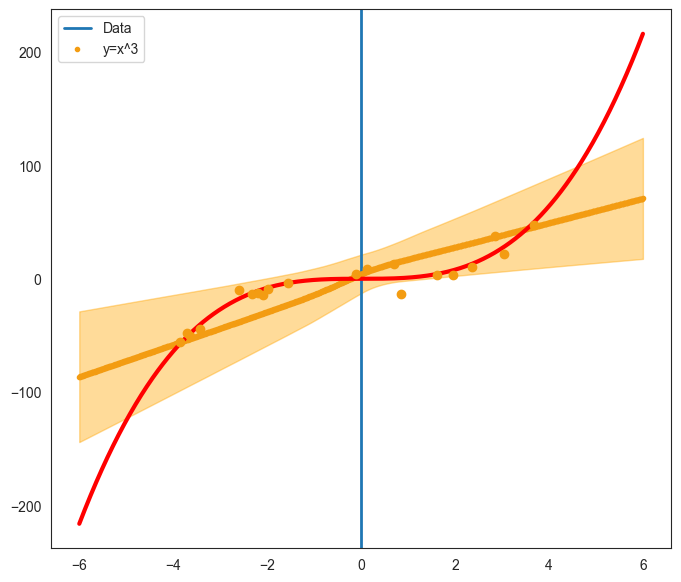

In [53]:
import numpy as np

mean = means.mean(0)
variance = (variances +  means.pow(2)).mean(0) - mean.pow(2)

std_devs = np.sqrt(variance.numpy()) * 3

upper = [i + k for i, k in zip(mean.numpy(), std_devs)]
lower = [i - k for i, k in zip(mean.numpy(), std_devs)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
plt.plot(data_x_true, mean, '.', markersize=6, color='#F39C12')
plt.fill_between(data_x_true.flatten(), upper, lower, color="orange", alpha=0.4)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()

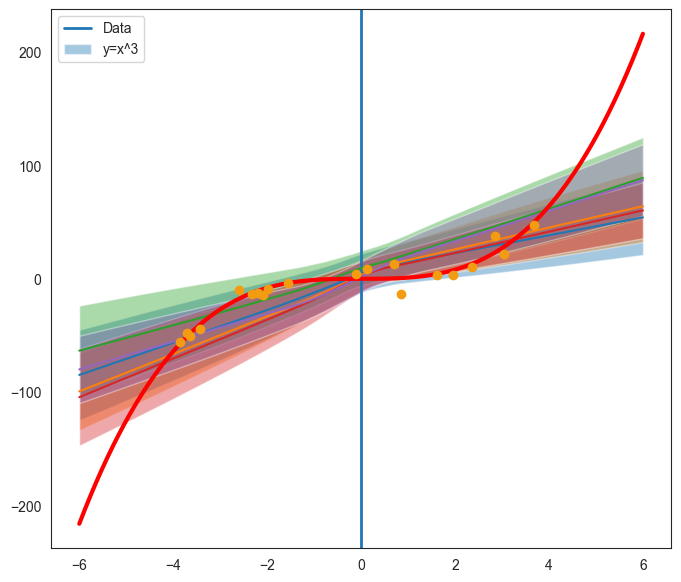

In [54]:
import numpy as np

mean = means.mean(0)
variance = (variances +  means.pow(2)).mean(0) - mean.pow(2)

std_devs = np.sqrt(variance.numpy()) * 3 / 2 

upper = [i + k for i, k in zip(mean.numpy(), std_devs)]
lower = [i - k for i, k in zip(mean.numpy(), std_devs)]

plt.rcParams['figure.figsize'] = [8, 7]
plt.axvline(x=0, linewidth=2)
for (mean, variance) in zip(means, variances):
    std = np.sqrt(variance.numpy()) * 3
    upper = [i + k for i, k in zip(mean.numpy(), std)]
    lower = [i - k for i, k in zip(mean.numpy(), std)]
    plt.fill_between(data_x_true.flatten(), upper, lower, alpha=0.4)
    plt.plot(data_x_true, mean)
plt.plot(data_x_true, data_y_true, 'r', linewidth=3)
plt.plot(data_x, data_y, '.', markersize=12, color='#F39C12')
plt.legend(['Data', 'y=x^3'], loc = 'best')
plt.show()